## Download the Sentiment140 Dataset from Kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eduardadonato","key":"600dc886ecfc1b353b71471885a92367"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
  0% 0.00/80.9M [00:00<?, ?B/s]
100% 80.9M/80.9M [00:00<00:00, 1.18GB/s]


In [ ]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet ( 2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)

## Libs

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 8.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import random
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import emoji

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, Input, GRU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
np.random.seed(42)

## Load and Preprocessing data

In [ ]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="latin-1", names=["sentiment", "id", "date", "query", "user", "text"])
df.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df_sample = df.sample(n=50000, random_state=42)
df_sample.head()

,sentiment,id,date,query,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [ ]:
df_sample['query'].value_counts()

,count
query,
NO_QUERY,50000


In [ ]:
df_sample = df_sample.drop(columns=['id', 'date', 'query', 'user'], axis=1)

In [ ]:
df_sample.head()

,sentiment,text
541200,0,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,@TiannaChaos i know just family drama. its la...
285055,0,School email won't open and I have geography ...
705995,0,upper airways problem


### Data cleaning

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def replace_emojis(text):
    new_text = ""
    for char in text:
        if char in emoji.EMOJI_DATA:
            name = emoji.demojize(char)                   # transforma em ":smile:"
            name = name.replace(":", "")
            new_text += f" <emoji_{name}> "
        else:
            new_text += char
    return new_text

In [ ]:
def preprocess_text(text):
    text = text.lower()                                   # minúsculas
    text = re.sub(r"http\S+|www.\S+", "<url>", text)      # remover URLs
    text = re.sub(r"@\w+", "<user>", text)                # remover menções
    text = re.sub(r"#", "", text)                         # remover #
    text = re.sub(r"[^\w\s]", "", text)                   # remover pontuação
    text = re.sub(r"\d+", "", text)                       # remover números
    text = re.sub(r"\s+", " ", text).strip()              # remover espaços extras

    text = replace_emojis(text)

    # remover stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

In [ ]:
df_sample['text'] = df_sample['text'].apply(preprocess_text)

df_sample['label'] = df_sample['sentiment'].map({0: 0, 4: 1})
df_sample.head()

,sentiment,text,label
541200,0,user ahhh hope ok,0
750,0,user cool tweet apps razr,0
766711,0,user know family drama lamehey next time u han...,0
285055,0,school email wont open geography stuff revise ...,0
705995,0,upper airways problem,0


In [ ]:
df_sample['label'].value_counts()

,count
label,
1,25014
0,24986


## Tokenizer

O vetor para entrar na LSTM precisa ser (batch_size,max_tokens, embedding_dimension)

max_tokens (padding)= qtd palavras que cada tweet deve ter

embedding_dimension = qtd de features que representa cada palavra/token e padding

In [ ]:
texts = df_sample['text'].tolist()
labels = df_sample['label'].values

word_counts = [len(text.split()) for text in texts]

In [ ]:
print("Máximo:", np.max(word_counts))

Máximo: 33


In [ ]:
int(np.percentile(word_counts, 95)) #95º percentil

15

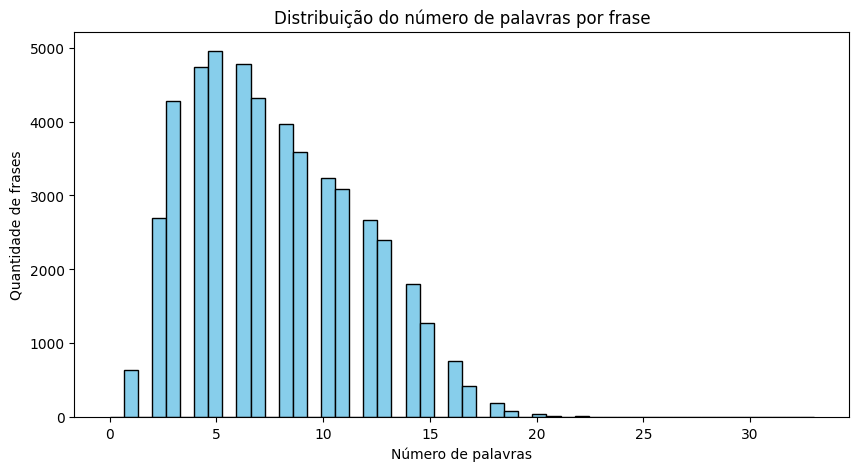

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(word_counts, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribuição do número de palavras por frase')
plt.xlabel('Número de palavras')
plt.ylabel('Quantidade de frases')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [ ]:
max_tokens = int(np.percentile(word_counts, 95))              #timestep
embedding_dimension = 50                                      #features
vocabulary_size = 5000
batch_size = 8

In [ ]:
tokenizer = Tokenizer(num_words=vocabulary_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_tokens, padding='post', truncating='post')
X_val = pad_sequences(X_val, maxlen=max_tokens, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_tokens, padding='post', truncating='post')

print(X_train.shape)
print(y_train.shape)

(32000, 15)
(32000,)


## Model

In [ ]:
model = Sequential([
    Input(shape=(max_tokens,)),
    Embedding(input_dim=vocabulary_size, output_dim=embedding_dimension),
    #LSTM(8, dropout=0.2),
    GRU(4, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 15, 50)         │       250,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 4)              │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,677 (979.21 KB)

 Trainable params: 250,677 (979.21 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    restore_best_weights=True,
    verbose=1,
    mode='auto'
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 74s 17ms/step - accuracy: 0.6249 - loss: 0.6181 - val_accuracy: 0.7524 - val_loss: 0.5118
Epoch 2/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 80s 16ms/step - accuracy: 0.7902 - loss: 0.4595 - val_accuracy: 0.7504 - val_loss: 0.5147
Epoch 3/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 94s 20ms/step - accuracy: 0.8112 - loss: 0.4241 - val_accuracy: 0.7534 - val_loss: 0.5201
Epoch 4/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 71s 17ms/step - accuracy: 0.8222 - loss: 0.3994 - val_accuracy: 0.7515 - val_loss: 0.5299
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


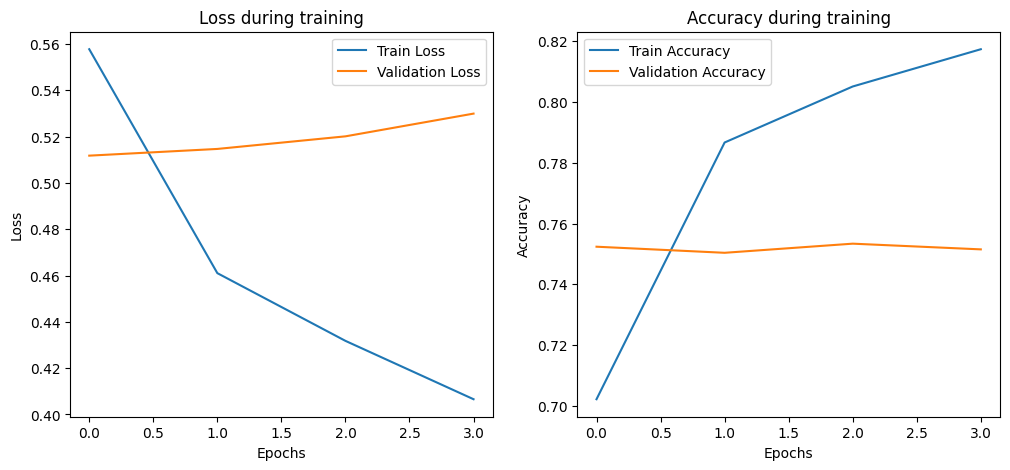

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7581 - loss: 0.5012


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Test Loss: 0.5025
Test Accuracy: 0.7573


In [ ]:
##y_pred_prob = model.predict(X_test)
#y_pred = (y_pred_prob > 0.5).astype(int).flatten()

## Examples

In [ ]:
def map_label(label):
    return "Positivo" if label == 1 else "Negativo"

In [ ]:
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Selecionar 5 exemplos aleatórios para exibir
sample_indices = np.random.choice(X_test.shape[0], size=5, replace=False)
test_samples = X_test[sample_indices]

print("\n--- 5 Exemplos de Predição do Conjunto de Teste ---\n")

for i, index in enumerate(sample_indices):
    original_text = df.loc[index, 'text']
    true_label_val = y_test[index]
    predicted_label_val = predicted_labels[index]
    
    print(f"Exemplo {i+1}:")
    print(f"  Tweet Original: {original_text}")
    print(f"  Rótulo Verdadeiro: {map_label(true_label_val)}")
    print(f"  Predição do Modelo: {map_label(predicted_label_val)}")
    print("-" * 20)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

--- 5 Exemplos de Predição do Conjunto de Teste ---

Exemplo 1:
  Tweet Original: Wow,strangely, I'm  calm. Thank God.  ok la, goodnight tweeteries  @simonpurwa hey,should play golf sometime yeah? 
  Rótulo Verdadeiro: Positivo
  Predição do Modelo: Positivo
--------------------
Exemplo 2:
  Tweet Original: @matthewkheafy write anything, cause all the albums are awesome haha 
  Rótulo Verdadeiro: Positivo
  Predição do Modelo: Positivo
--------------------
Exemplo 3:
  Tweet Original: @DavidRN107 I'm sorry  that sucks!
  Rótulo Verdadeiro: Negativo
  Predição do Modelo: Negativo
--------------------
Exemplo 4:
  Tweet Original: @hughsbeautiful Because it aired already  I can get BBC 1 and 2 on my television. And Hugh was brilliant! :p
  Rótulo Verdadeiro: Positivo
  Predição do Modelo: Positivo
--------------------
Exemplo 5:
  Tweet Original: @kamla I envy U! You're watching classics &amp; I'm getting ready 4 work. Do let me know about your th

## Embedding pré-treinado (GloVe)

EMBEDDINGS (Word2Vec, GloVe)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-08-28 12:16:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-08-28 12:16:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-08-28 12:16:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
glove_path = "glove.6B.50d.txt"

In [ ]:
embeddings_index = {}

with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vector

print("Total de vetores GloVe carregados:", len(embeddings_index))

Total de vetores GloVe carregados: 400000


In [ ]:
vocab_size = len(tokenizer.word_index) + 1  # +1 para o índice 0 (padding)

embedding_matrix = np.zeros((vocab_size, embedding_dimension))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Formato da matriz de embeddings:", embedding_matrix.shape)

Formato da matriz de embeddings: (31028, 50)


## Model 2

In [ ]:
model_g = Sequential([
    Input(shape=(max_tokens,)),
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dimension,
        weights=[embedding_matrix],
        trainable=True
    ),
    #LSTM(8, return_sequences=False),
    GRU(4),
    Dense(1, activation='sigmoid')
])

model_g.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model_g.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)        │ (None, 15, 50)         │     1,551,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 4)              │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,552,077 (5.92 MB)

 Trainable params: 1,552,077 (5.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto'
)

history = model_g.fit(
    X_train, y_train,
    epochs=10,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 105s 26ms/step - accuracy: 0.6325 - loss: 0.6162 - val_accuracy: 0.7486 - val_loss: 0.5148
Epoch 2/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 99s 25ms/step - accuracy: 0.7858 - loss: 0.4617 - val_accuracy: 0.7509 - val_loss: 0.5145
Epoch 3/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 150s 27ms/step - accuracy: 0.8085 - loss: 0.4238 - val_accuracy: 0.7523 - val_loss: 0.5175
Epoch 4/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 113s 28ms/step - accuracy: 0.8261 - loss: 0.3921 - val_accuracy: 0.7479 - val_loss: 0.5303
Epoch 5/10
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 131s 25ms/step - accuracy: 0.8412 - loss: 0.3677 - val_accuracy: 0.7496 - val_loss: 0.5482
Epoch 5: early stopping


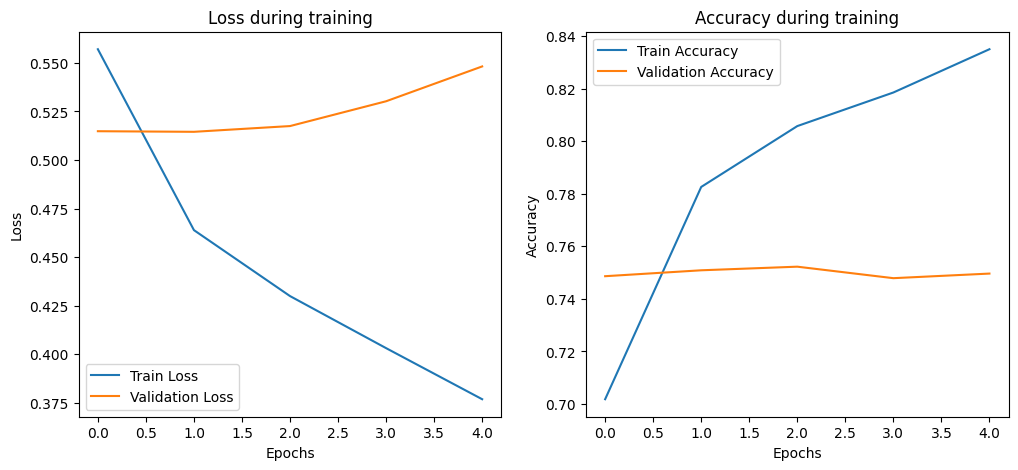

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Examples

In [ ]:
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Selecionar 5 exemplos aleatórios para exibir
sample_indices = np.random.choice(X_test.shape[0], size=5, replace=False)
test_samples = X_test[sample_indices]

print("\n--- 5 Exemplos de Predição do Conjunto de Teste ---\n")

for i, index in enumerate(sample_indices):
    original_text = df.loc[index, 'text']
    true_label_val = y_test[index]
    predicted_label_val = predicted_labels[index]
    
    print(f"Exemplo {i+1}:")
    print(f"  Tweet Original: {original_text}")
    print(f"  Rótulo Verdadeiro: {map_label(true_label_val)}")
    print(f"  Predição do Modelo: {map_label(predicted_label_val)}")
    print("-" * 20)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

--- 5 Exemplos de Predição do Conjunto de Teste ---

Exemplo 1:
  Tweet Original: Wow,strangely, I'm  calm. Thank God.  ok la, goodnight tweeteries  @simonpurwa hey,should play golf sometime yeah? 
  Rótulo Verdadeiro: Positivo
  Predição do Modelo: Positivo
--------------------
Exemplo 2:
  Tweet Original: @matthewkheafy write anything, cause all the albums are awesome haha 
  Rótulo Verdadeiro: Positivo
  Predição do Modelo: Positivo
--------------------
Exemplo 3:
  Tweet Original: @DavidRN107 I'm sorry  that sucks!
  Rótulo Verdadeiro: Negativo
  Predição do Modelo: Negativo
--------------------
Exemplo 4:
  Tweet Original: @hughsbeautiful Because it aired already  I can get BBC 1 and 2 on my television. And Hugh was brilliant! :p
  Rótulo Verdadeiro: Positivo
  Predição do Modelo: Positivo
--------------------
Exemplo 5:
  Tweet Original: @kamla I envy U! You're watching classics &amp; I'm getting ready 4 work. Do let me know about your th